# 4. 모델훈련

## 4.1 선형회귀

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

모델 훈련 = 모델이 훈련세트에 가장 알맞도록 하는 모델 파라미터를 설정하는 것

모델 훈련을 위해 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정 필요

회귀에서의 측정지표 -> RMSE(평균 제곱근 오차)
그러나 실제로는 MSE(평균 제곱 오차)를 최소화 하는것이 간단함

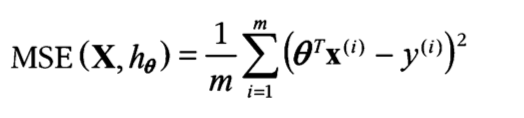

## 4.1.1 정규방정식

정규방정식(normal equation): 비용함수를 최소화 하는 세타값을 찾기위한 해석적인 방법

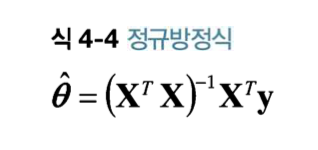

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_plot


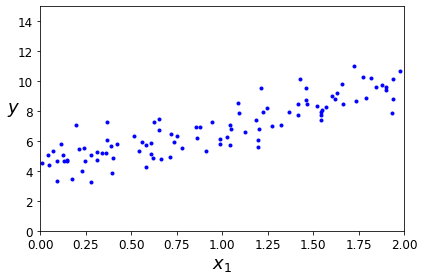

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)   #inv()= 역행렬 , dot() = 행렬곱셈

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

원래 함수 =>  y = 3x + 4

세타0=4 세타1=3

정규방정식으로 예측한 파라미터: 세타0 = 4.2 세타1 = 2.7  
비슷하게 예측하긴 했지만 잡음때문에 정확한 예측은 못함

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

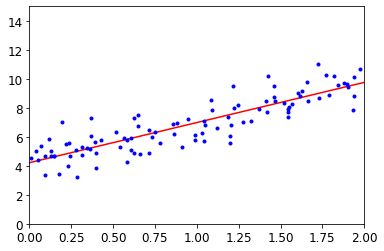

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [10]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [11]:
np.linalg.pinv(X_b).dot(y) #유사역행렬(무어-펜로즈 역행렬)구하는 함수

array([[4.21509616],
       [2.77011339]])

## 4.1.1 계산 복잡도

정규방정식은 (n+1)x(n+1)크기의 X transpose, X의 역행렬 계산을 한다.  
역행렬 계산의 계산 복잡도는 일반적으로 O(n^2.4) , O(n^3)사이이다.  
즉 특성수가 두배로 늘어난다면 계산시간이 대략 2^2.4(5.3배) ~ 2^3(8배)배 증가한다. 

LinearRegression클래스가 사용하는 svd방법은 약 O(n^2)이다.

정규방정식과 svd방법 모두 특성 수가 많아지면 계산이 몇배로 느려지지만, 샘플 수의 증가에 대해서는 선형적으로 증가한다

## 4.2 경사하강법

경사하강법(gradient descent):일반적인 최적화 알고리즘, 비용함수를 최소화 하기위한 파라미터 반복 조정

-> 구체적인 방법: 세타값을 임의로 시작해서(무작위 초기화) 비용함수가 감소하는 방향으로 진행하여 알고리즘이 최솟값에 수렴할때까지 반복

학습률: 경사하강법에서 중요한 파라미터, 스텝의 크기를 조정하는 하이퍼파라미터, 너무 작으면 수렴하기까지 너무 오래걸리고, 너쿠 크면 발산함

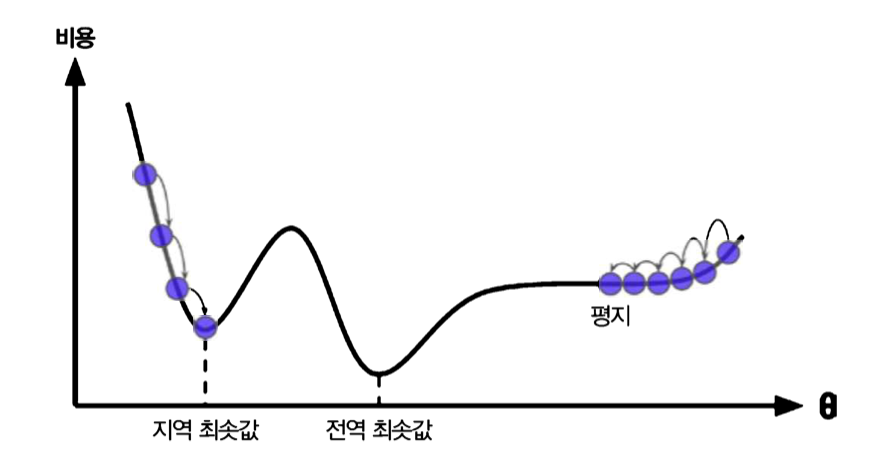

위 그림 처럼 비용함수가 매끄러운 볼록함수가 아니라면 두가지 문제가 발생함
1. 왼쪽에서부터 시작하면 전역최솟값이라는 더 좋은 값보다 덜 좋은 지역최솟값에서 수렴하게됨
2. 오른쪽에서부터 시작하면 평탄한 부분에서 수렴하기까지의 시간이 오래걸림, 시간상 전역최솟값에 도달하기 힘듬

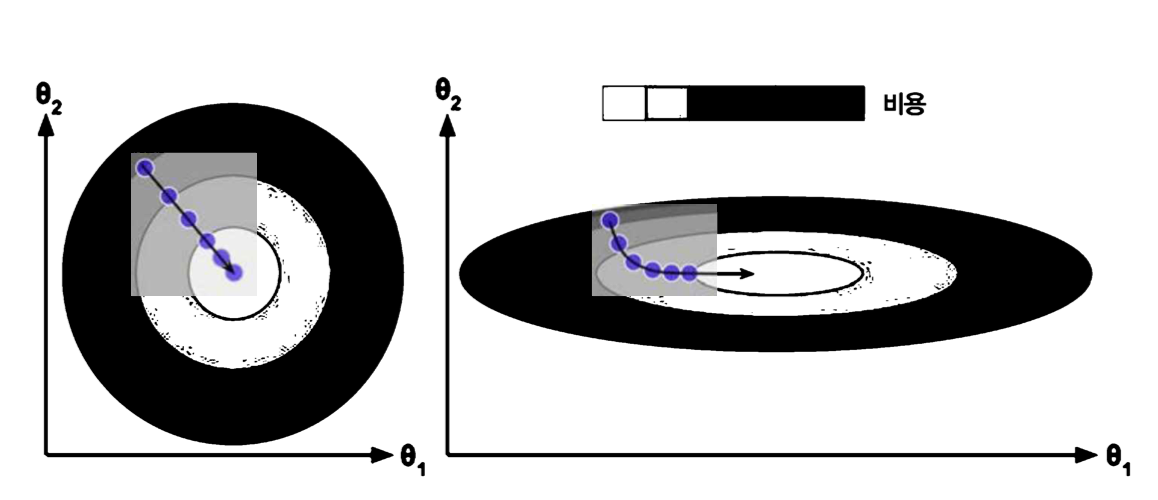

특성 스케일링을 하지 않으면 두번째 그림처럼 최솟값으로 가는게 더 오래걸림
모든 특성을 그 특성의 해당 단위수로 나눠주어서 맞춤  

ex) x1 = 집의 크기(0-1000 m^2), x2 = 방의 수(0-5개)
스케일링 -> x1/1000 ,   x2/5

모든 특성이 -1에서 1의 범위에 있도록 조정함

## 4.2.1 배치 경사 하강법

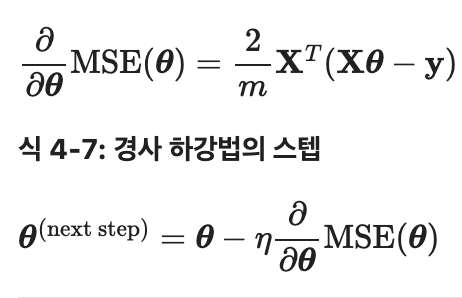

편도함수: 모델 파라미터 세타에 대해 비용함수의 변화를 계산하는 함수

배치 겨상 하강법: 이름이 직관적으로 이해되진 않지만, 전체 경사하강법 정도로 이해하면 직관적임.   
앞선 공식들을 모든 훈련세트에 대하여 동시에 계산하는 것이기 때문에 이러한 이름이 생김

경사 하강법은 특성수에는 민감하지 않지만, 훈련세트 수가 많아지면 매우 느려짐

In [13]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

경사하강법 실행

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

정규방정식이 구한 세타값과 같음

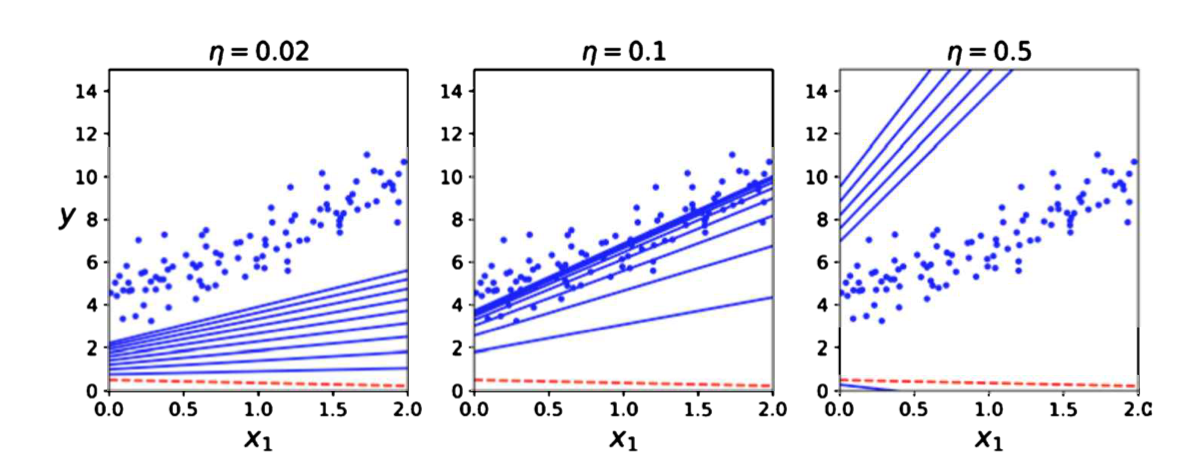

학습률에 따른 경사하강법 차이

왼쪽: 학습률이 너무 낮아서 시간이 너무 오래걸림  
가운데: 적당함  
오른쪽: 학습률이 너무 커서 발산함  

적절한 학습량을 찾기 위해선 그리드 탐색을 이용함.
하지만 그리드 탐색에서 수렴하는데 너무 오래 걸리는 모델을 막기위해 반복횟수를 제한해야함.

반복횟수가 너무 작으면 수렴하기전에 알고리즘이 멈추고, 너무 크면 시간이 낭비됨

해결책:반복 횟수를 아주 크게하고, 그레디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값 입실론(허용오차)보다 작아지면  
경사하강법이 거의 최솟값에 도달하는 것이므로 알고리즘을 중지하게함

## 4.2.2 확률적 경사하강법

확률적 경사하강법: 배치 경사하강법의 단점(전체 훈련세트를 모두 사용해 느리다는것)을 보완한 방법 

매 스텝에서 무작위로 한개의 샘플을 선택하고, 그래디언트를 계산함 -> 빠르고, 메모리 필요도 적음

단점: 배치 경사 하강법 보다 불안정적임(상황에 따라 지역 최솟값을 탈출할 가능성은 높지만, 전역 최솟값에 완벽히 다다르진 못함)  
->해결책: 학습률을 크게 한후 점점 줄여 나가 전역 최솟값을 찾게 만드는 담금질 알고리즘과 유사한 방법 사용  

반복에서 학습률을 결정하는 함수를 학습 스케쥴이라고 부름

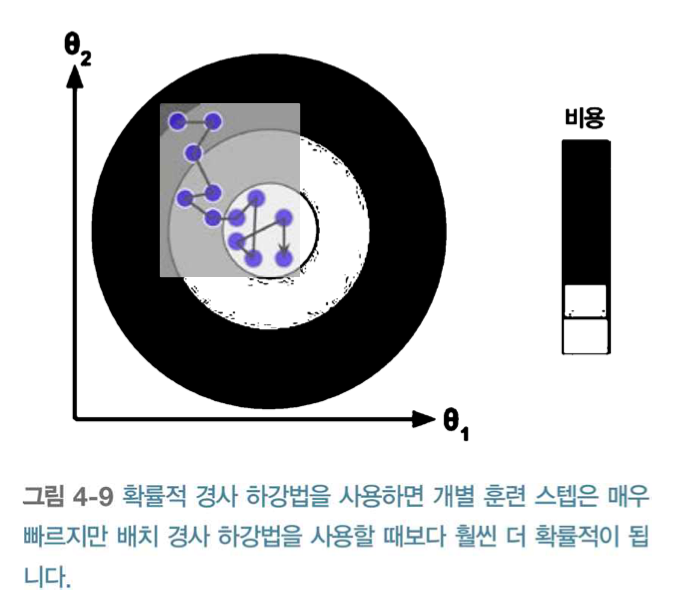

In [15]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


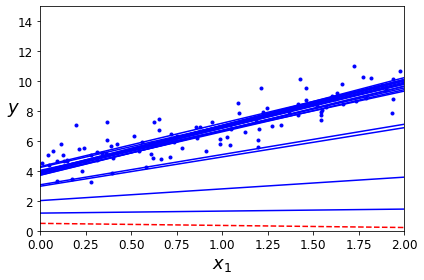

In [16]:
# 확률적 경사 하강법 구현
n_epochs = 50        
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                  
plt.ylabel("$y$", rotation=0, fontsize=18)        
plt.axis([0, 2, 0, 15])                           
save_fig("sgd_plot")                               
plt.show()                                           

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

In [18]:
#사이킷런을 활용하기
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

## 4.2.3 미니배치 경사 하강법

미니배치 경사하강법: 각 스텝마다 임의 작은 샘플'세트'에 대한 그레디언트 계산하는것

미니배치 경사 하강법과 확률적 경사하강법의 개념차이 : https://mazdah.tistory.com/838

In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [21]:
theta

array([[4.25214635],
       [2.7896408 ]])

각 방법마다 움직인 경로
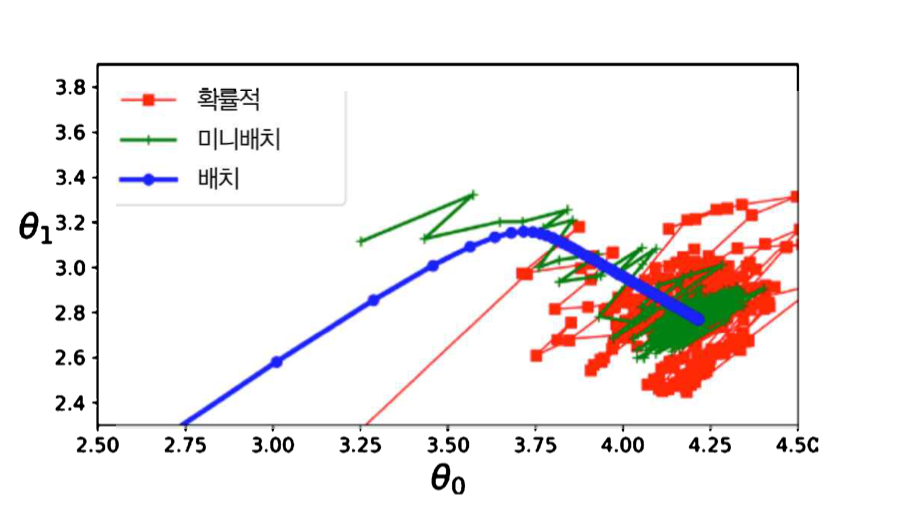

대략 4.25, 2.8정도인 최솟값을 배치 경사하강법은 정확히 최솟값에 멈춘 반면, 확률적 경사하강법과 미니 배치하강법은 맴돌고 있는 것이 보임  
그러나 각 스텝마다의 시간은 배치 경사하강법이 많이 소요되고, 적잘한 학습 스케줄을 사용하면, 확률적 경사하강법이나 미니 배치하강법도 최솟값에 도달할 수 있음

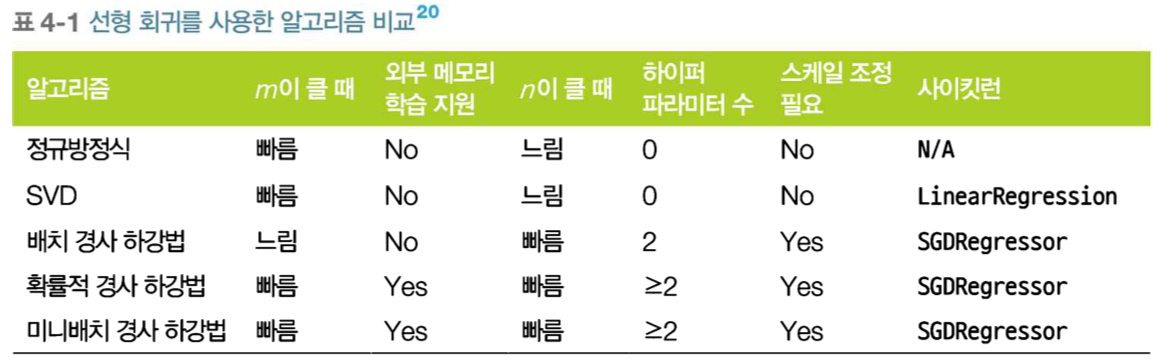

## 4.3 다항회귀

비선형 데이터를 학습하는 선형 모델을 사용하는 것  
각 특성의 거듭제곱을 새로운 특성으로 추가하고 이 확장된 데이터셋에 선형모델을 훈련시키는 방법

그림 저장: quadratic_data_plot


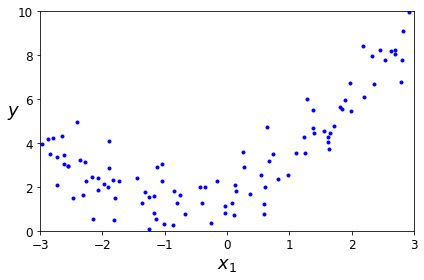

In [23]:
# 2차 방정식을 활용해 비선형 데이터 (+ 약각의 잡음) 만들기

import numpy as np
import numpy.random as rnd

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

직선은 이 데이터에 잘 맞지 않음  
그러므로 사아킷런을 사용해 훈련데이터를 변환(훈련세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가)

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [25]:
# X_poly = 원래 특성 x와 이 특성의 제곱을 포함
X_poly[0]

array([-0.75275929,  0.56664654])

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


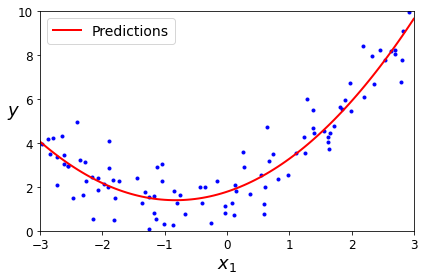

In [27]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

일반적인 선형회귀에서는 불가능하지만 다항회귀는 특성이 여러 개일때 각 특성 사이의 관계를 찾을 수 있다.  
-> PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항도 추가하기 때문이다.

## 4.4 학습곡선

그림 저장: high_degree_polynomials_plot


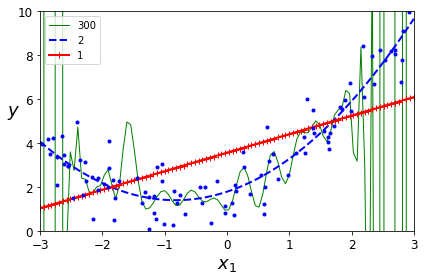

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 함  
그러나 과대적합이 일어 날 수 있음, 그래프에서 처럼 2차 다항회귀는 잘나왔지만, 1차는 과소적합, 300차는 과대적합된걸 볼 수 있음

모델의 과대적합 과소적합을 확인하는 법  
1. 교차 검증 사용하기  
성능 테스트에서 훈련 데이터에서는 성능이 좋지만, 교차 검증 점수가 나쁘다면 과대적합된것임  


2. 학습곡선 살펴보기  
학습곡선이란 훈련세트와 검증세트의 모델 성능을 훈련세트 크기(혹은 훈련 반복)의 함수를 나타낸것나타낸것

In [38]:
# 과소적합된 사례(단순 선형회귀모델)의 학습곡선

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

그림 저장: underfitting_learning_curves_plot


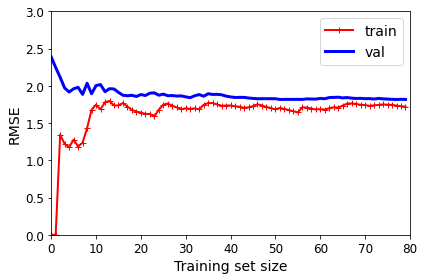

In [34]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()                                      

### 과소적합된 모델  

이 학습곡선은 과소적합 모델의 전형적인 모습, 두 고선이 수평한 구간을 만들고 높은 오차에서 매우 근접해 있음 (훈련샘플을 더 추가해도 의미없음)

1. 훈련데이터 성능  
훈련 세트에 샘플이 추가됨에 따라 잡음도 있고, 비선형이기에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해짐
-> 그래서 곡선이 어느정도 평편해질때까지 오차가 계속 상승함

2. 검증데이터 성능  
적은 수의 훈련샘플로 훈련될때에는 일반화할 수 없어 초기에 오차가 매우 큼, 모델의 훈련샘플이 추가됨에 따라 검증오차가 천천히 감소함  
그러나 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워짐


그림 저장: learning_curves_plot


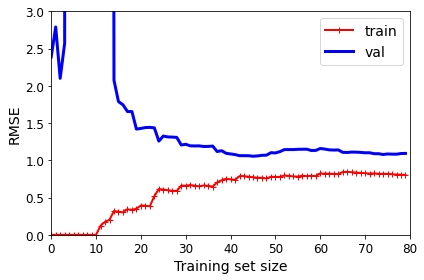

In [37]:
# 과대적합된 사례(10차 다항회귀모델)의 학습곡선

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
save_fig("learning_curves_plot")  
plt.show()                        

### 과대적합된 모델

1. 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음  


2. 두 곡선 사이의 공간이 있음. 즉 훈련 데이터에서의 모델 성능이 검증 데이터보다 좋다는 것을 뜻함 (더 큰 훈련세트를 사용하면 두 곡선은 점점 가까워짐)

편향/분산 트레이드오프

모델이 복잡도가 커지면 통상적으로 분산(variance)이 늘어나고 편향(bias)이 줄어들음, 모델의 목잡도가 줄어들면 편향(bias)이 커지고 분산이 작아짐

과소적합 = high bias, low variance  
과대적합 = low bias,  high variance

## 4.5 규제가 있는 선형모델

과대적합을 감소시키는 좋은 방법: 모델을 규제하는 것

자유도를 줄이면 데이터에 과대적합되기 더 어려워짐, 다항 회귀 모델을 규제하는 방법은 다항식의 차수를 감소시키는것

선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함

## 4.5.1 릿지 회귀

릿지 회귀(또는 티호노프 규제)는 규제항이 비용함수에 추가하는 방법으로 규제를 추가한다.  
이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 함
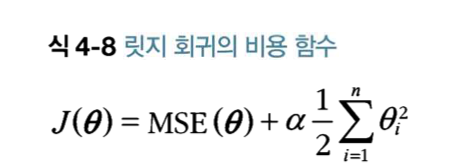

하이퍼 파라미터 알파가 모델의 규제정도를 조절함  
알파가 0이면 규제가 없는것이고, 알파가 매우 크면 모든 가중치가 거의 0이되고 데이터의 평균을 지나는 수평선이됨  
세타0은 규제에서 제외됨

In [44]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

그림 저장: ridge_regression_plot


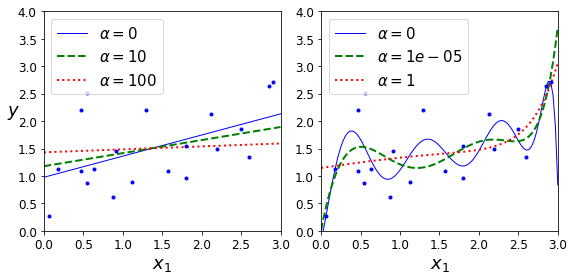

In [45]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

## 4.5.2 라쏘 회귀


라쏘 회귀는 선형회귀의 규제된 버전, 릿지회귀 처럼 비용함수에 규제항을 더하지만, 다른 노름을 사용
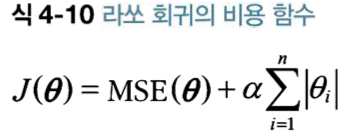

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8028677038274186, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


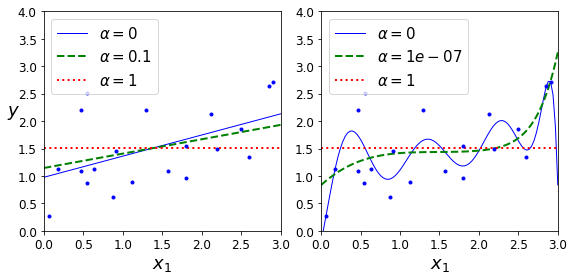

In [47]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

라쏘 회귀의 특징은 덜 중요한 특성의 가중치를 제거하려고함 즉 자동으로 특성 선택을 하고 희소모델을 만듬

In [48]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [52]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


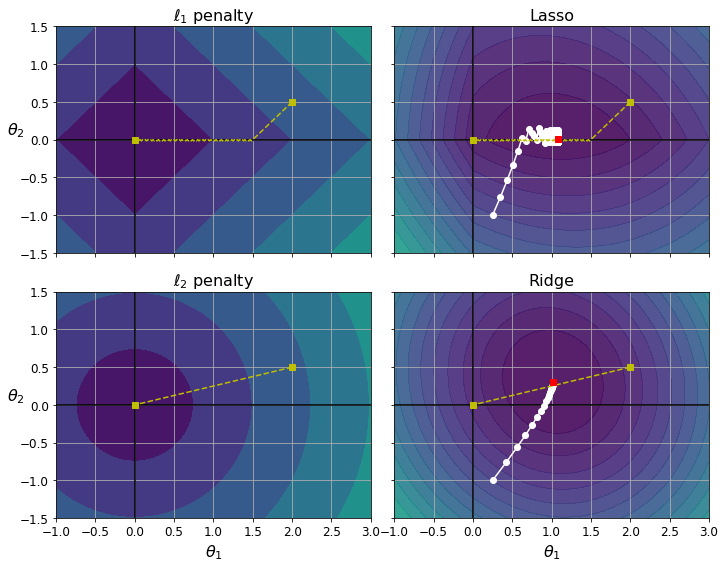

In [55]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

## 4.5.2 엘라스틱넷 

엘라스틱넷은 릿지회귀와 라쏘회귀를 절충한 모델이다.  
규제항을 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합정도는 혼합비율r을 사용해 조절 r=0이면 릿지와 같고, r=1이면 라쏘와 같음
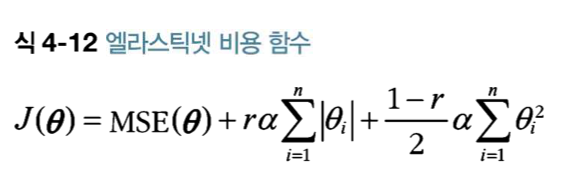

정규화 모델(릿지, 라쏘, 엘라스틱넷 정보)  
https://blog.naver.com/winsik111/222450914279

## 4.5.4 조기종료

반복적인 학습 알고리즘을 규제하는 다른 방법은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지 시키는 조기종료 방법이 있다.

In [49]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [50]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그림 저장: early_stopping_plot


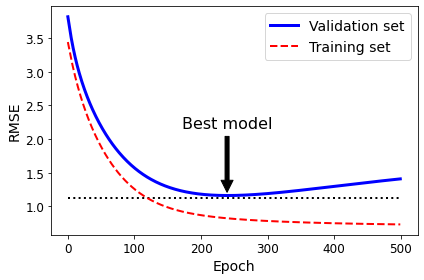

In [51]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

에포크가 진행됨에 따라 알고리즘이 학습되어 훈련 세트에 대한 예측에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어든다.  
그러나 감소하던 검증 에러가 멈추었다가 다시 증가하는 모습을 보여주는데 이는 모델이 훈련데이터에 과대적합되기 시작했다는것을 보여준다.  
조기종료는 검증에러가 최소가 되는 시점에서 즉시 훈련을 멈추어 과대적합을 막는다.

## 4.6 로지스틱 회귀

로지스틱 회귀: 분류에 사용되는 회귀 알고리즘

이진 분류기: 레이블이 1인 양성클래스, 레이블이 0인 음성 클래스 둘중 하나에 속하는지를 판단하는 분류기

## 4.6.1 확률 추정

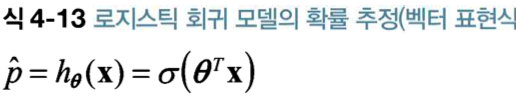

로지스틱은 0과 1사이의 값을 출력하는 시그모이드 함수이다.

그림 저장: logistic_function_plot


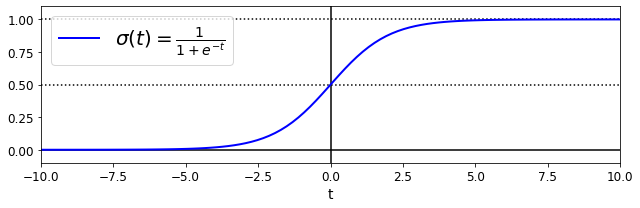

In [56]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

로지스틱 회귀 모델이 샘플x가 양성 클래스에 속할 확률을 추정하면 이에 대한 y 를 쉽게 구할 수 있다

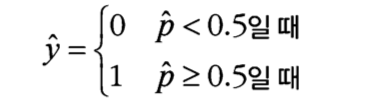

t<0 이면 로지스틱 함수 < 0.5이고, t>0이면 로지스틱 함수>= 0.5 이므로 로지스틱 회귀 모델은 h(x)가 양수일 때 1(양성),음수일때 0(음성)이다.

## 4.6.2 훈련과 비용 함수

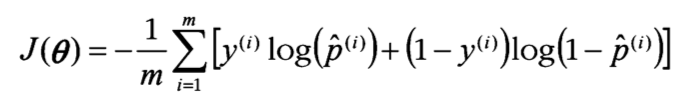

자세한 설명은 밑에 필기로

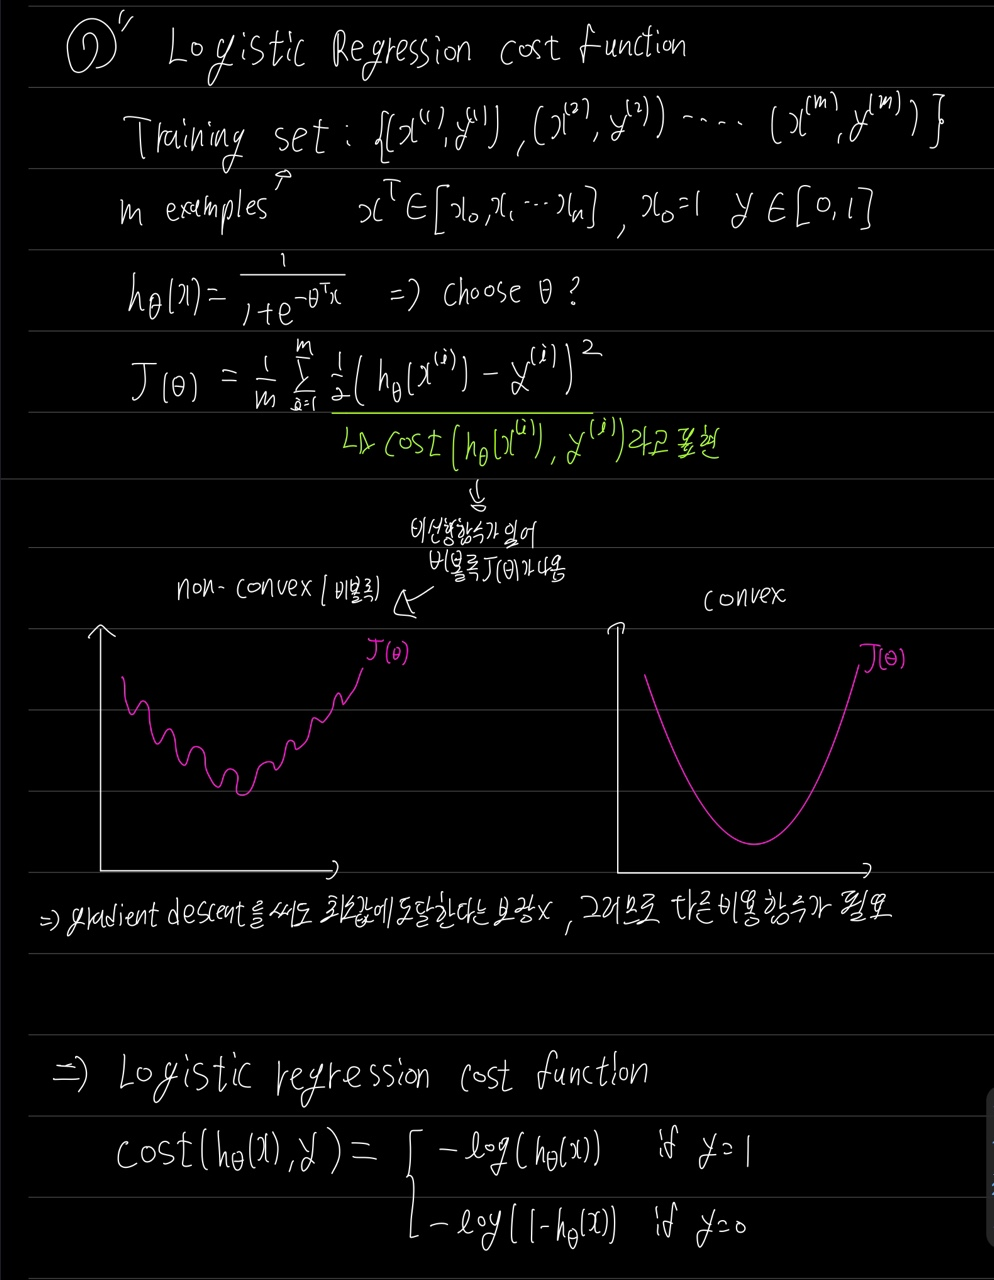

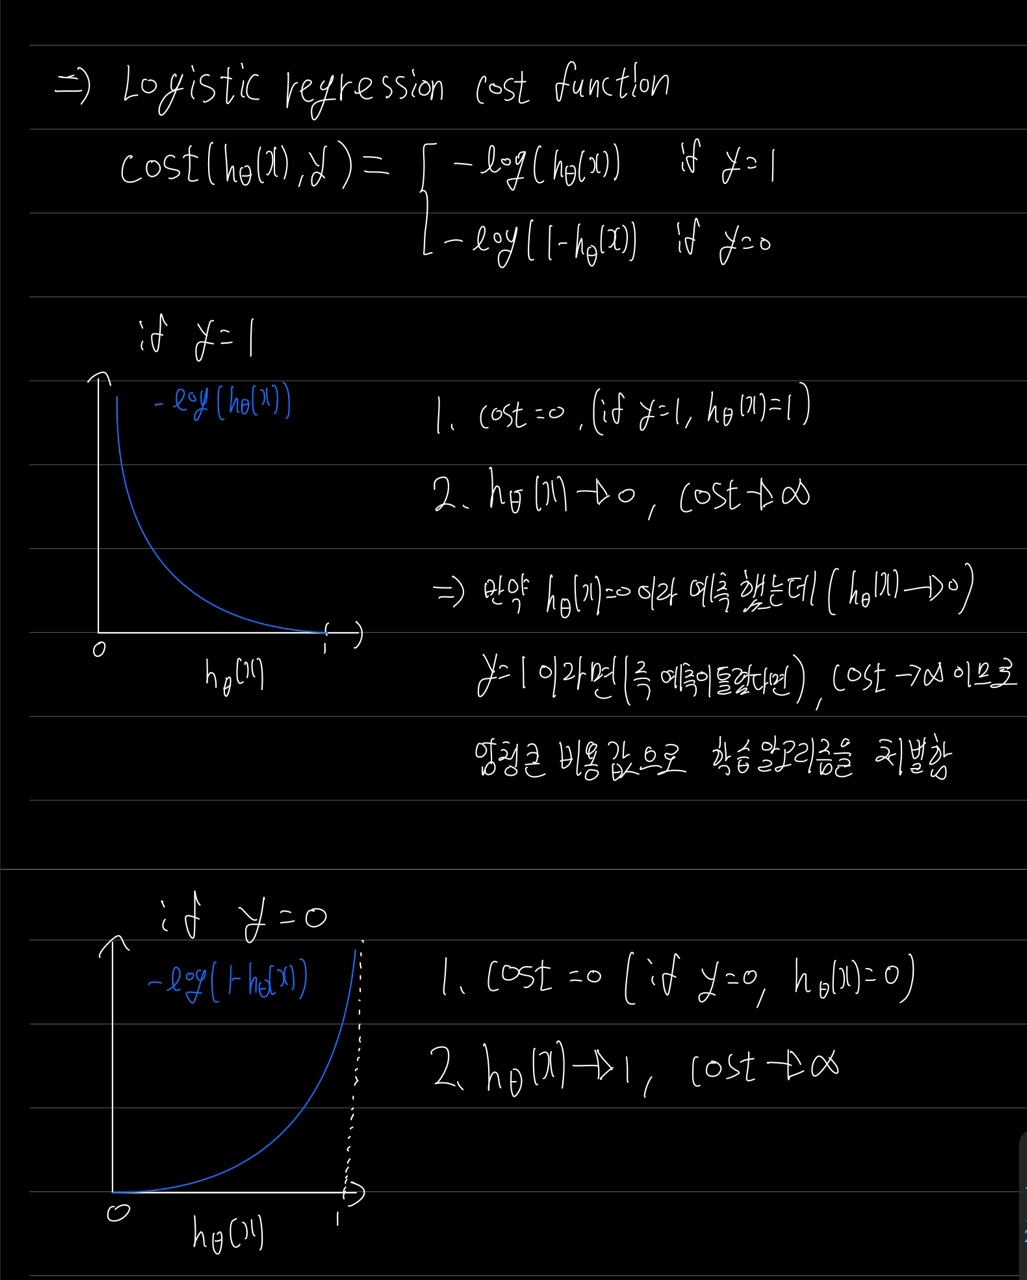

## 4.6.3 결정 경계

In [59]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [60]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(int)  # Iris virginica이면 1 아니면 0

꽃잎의 너비를 기준으로 Iris-Versicolor종을 감지하는 분류기 만들기

In [61]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

그림 저장: logistic_regression_plot


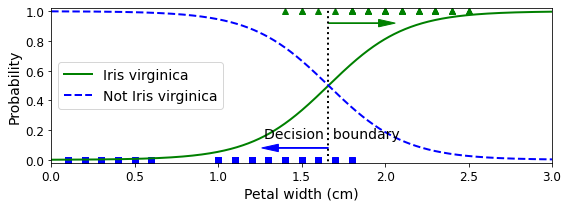

In [63]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [65]:
decision_boundary

array([1.66066066])

Iris-Versicolor 꽃잎 너비는 1.4에서 2.5cm에 분포되고, 다른 붓꽃은 일반적으로 꽃잎의 너비가 0.1에서 1.8에 분포된다.  
그러므로 약간의 중첩된 부분이 존재하고, 2cm이상과 1cm아래에 대해선 강한 확신을 보여준다.  
확률이 50%되는 1.6cm을 근방으로 decision boundary(결정경계)가 만들어진다.  
즉 1.6보다 크면 Iris-Versicolor로 분류하고 그보다 작으면 아니라고 예측할것임.

In [64]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

그림 저장: logistic_regression_contour_plot


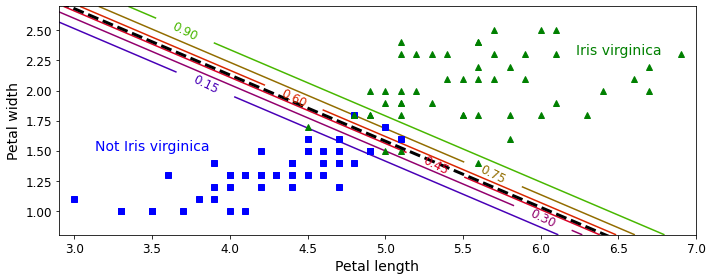

In [66]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

## 4.6.4 소프트맥스 회귀

로지스틱 회귀 모델은 여러 이진 분류기를 연결하지 않고 직접 다중 분류기를 지원할 수 있다. 이를 소프트맥스 회귀 또는 다항 로지스틱회귀라고 한다.

샘플x가 주어지면 먼저 소프트맥스 회귀모델이 각 클래스 k에 대한 Sk(x)를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률 추정

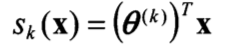

각 클래스는 자신만의 파라미터 벡터 세타가 있고, 이 벡터들을 파라미터 행렬에 행으로 저장된다.  
샘플x에 대한 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 활률 p를 추정할 수 있다.
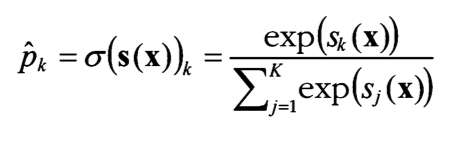

이 함수는 각 점수에 지수 함수를 적용한 후 정규화를 함. 이 점수를 일반적으로 로짓 또는 로그-오즈라고 부름.

로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기 또한 추정 확률이 가장 높은 클래스를 선택함
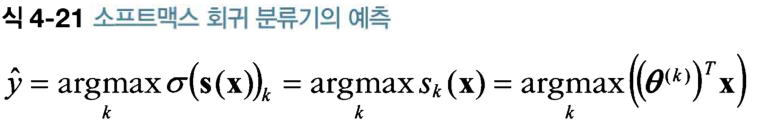

크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용된다.
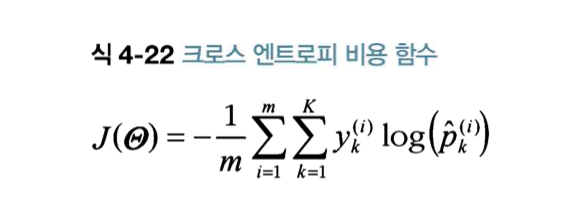

In [68]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

그림 저장: softmax_regression_contour_plot


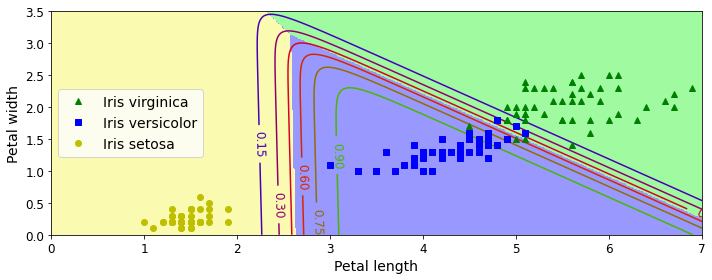

In [69]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [73]:
softmax_reg.predict([[5, 2]])

array([2])

꽃잎의 길이가 5 너비가 2인 붓꽃의 품종을 클래스 2로 분류함

In [74]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

순서대로 각 클래스에 속할 확률, 클래스 2의 확률이 제일높으므로 클래스2 출력